In [96]:
%matplotlib inline

In [97]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression

In [98]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2010-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,30.447144,30.478571,30.080000,30.104286,26.061205,88102700
2010-01-04,30.490000,30.642857,30.340000,30.572857,26.466835,123432400
2010-01-05,30.657143,30.798571,30.464285,30.625713,26.512596,150476200
2010-01-06,30.625713,30.747143,30.107143,30.138571,26.090879,138040000
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.042646,119282800


In [99]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

In [106]:
df['Date']

0      2009-12-31
1      2010-01-04
2      2010-01-05
3      2010-01-06
4      2010-01-07
          ...    
2594   2020-04-23
2595   2020-04-24
2596   2020-04-27
2597   2020-04-28
2598   2020-04-29
Name: Date, Length: 2599, dtype: datetime64[ns]

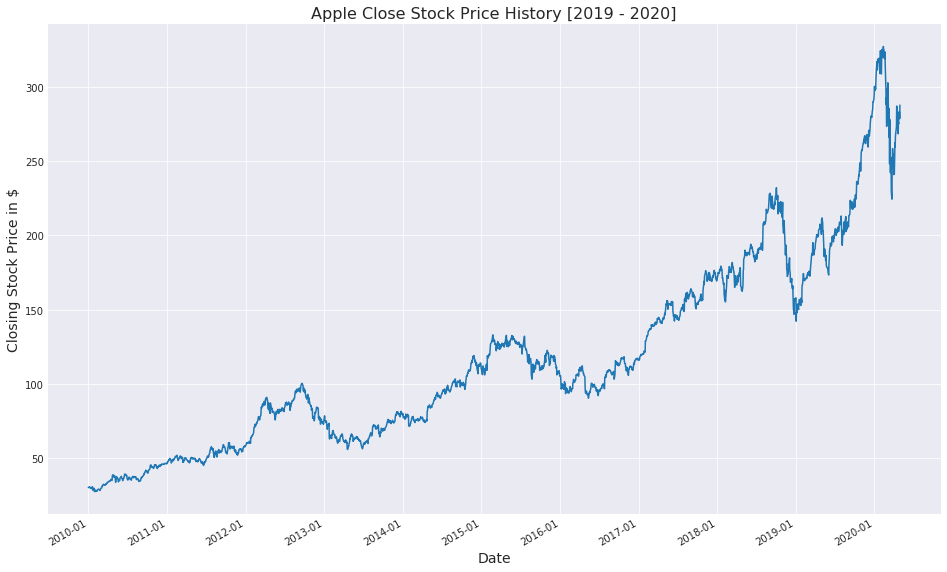

In [76]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
months = mdates.YearLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [13]:
def get_close_stock_price(codes, start_date='2010-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [407]:
df = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.describe()
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2012-05-18,75.768570,300.500488,29.270000,213.850006,38.230000
2012-05-21,80.182854,307.362366,29.750000,218.110001,34.029999
2012-05-22,79.567146,300.700714,29.760000,215.330002,31.000000
2012-05-23,81.508568,305.035034,29.110001,217.279999,32.000000
2012-05-24,80.760002,302.132141,29.070000,215.240005,33.029999


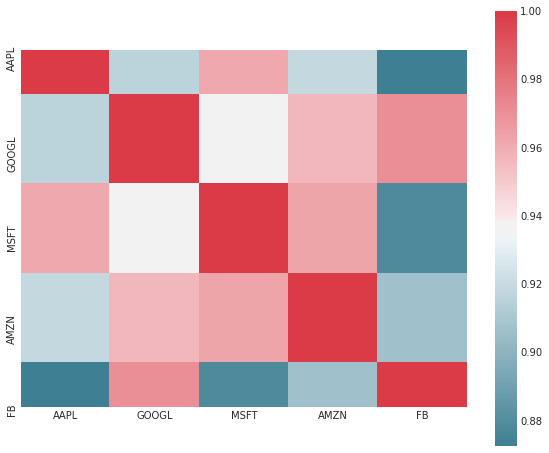

In [506]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [409]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

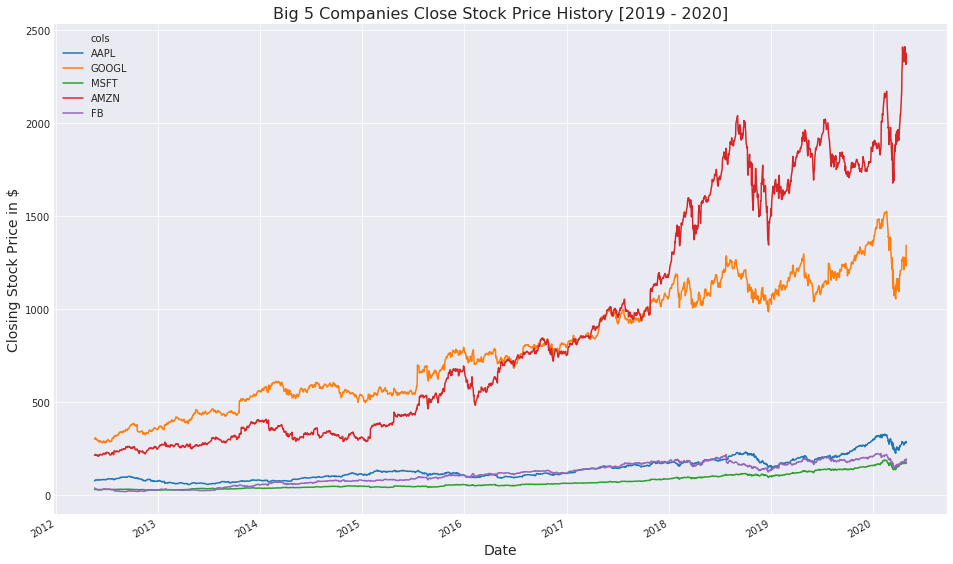

In [410]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

In [411]:
def compute_weights(pasts, cur):
    w = [(32 - (cur-past).days) / 31 for past in pasts]
    return w

In [412]:
weights = df.index[0:5]

w = compute_weights(weights, df.index[5])
print(w)
tmp = df.iloc[0:5, :].values.copy()
print(tmp * w)

[0.8064516129032258, 0.9032258064516129, 0.9354838709677419, 0.967741935483871, 1.0]
[[ 61.10368544 271.41979587  27.38161333 206.95161881  38.22999954]
 [ 64.66359169 277.61762065  27.83064516 211.07419414  34.02999878]
 [ 64.16705347 271.600645    27.84000021 208.38387274  31.        ]
 [ 65.73271598 275.51551474  27.23193605 210.27096656  32.        ]
 [ 65.12903398 272.89354681  27.19451584 208.29677951  33.02999878]]


In [495]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
#         y.append( (df.iloc[row_idx,:].values-df.iloc[row_idx-1,:].values + 1e-18).reshape(-1) )
#         tmp = df.iloc[row_idx-history:row_idx, :].values.copy()
#         tmp = tmp[1:] / tmp[:-1]
#         weights = compute_weights(df.index[row_idx-history:row_idx], df.index[row_idx])
#         for i, w in enumerate(weights):
#             tmp[i] *= w
#         X.append( tmp.reshape(-1) )
#         X.append((tmp[1:]-tmp[:-1]).reshape(-1))
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    
    X, y = np.array(X), np.array(y)
    return X, y, dates

X, y, dates = create_Xy(df, history=2)
# y = y - X.reshape(-1, 5, 5)[:, -1, :]
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 5 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

In [496]:
X.shape, y.shape, y_train.shape, y_test.shape

((1997, 10), (1997, 5), (998, 5), (999, 5))

In [497]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error as err

In [498]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
print(err(y_test, ypred))
rel = (abs(ypred - y_test) / abs(y_test)).sum()
print(rel)

252.30756246244613
64.32045700171534


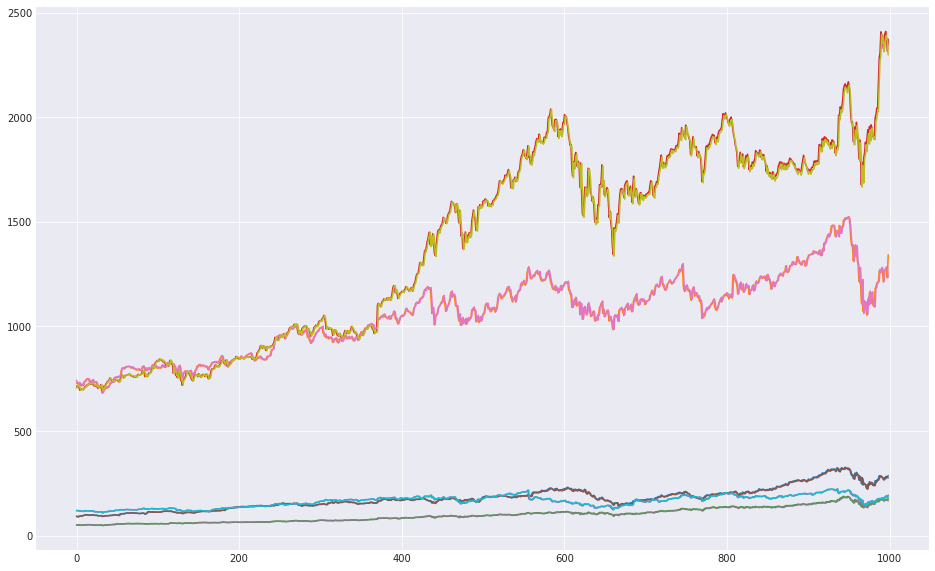

In [499]:
plt.plot(y_test[:, :])
plt.plot(ypred[:, :])

In [394]:
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
kernel = 1.0 * RBF(3.0)
kernel = RationalQuadratic(1.0)
clf = KernelRidge(alpha=0.001, kernel_params=kernel)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
print(err(y_test, ypred))
rel = (abs(ypred - y_test) / abs(y_test)).sum()
print(rel)

450.99657197780533
30.834578346439955


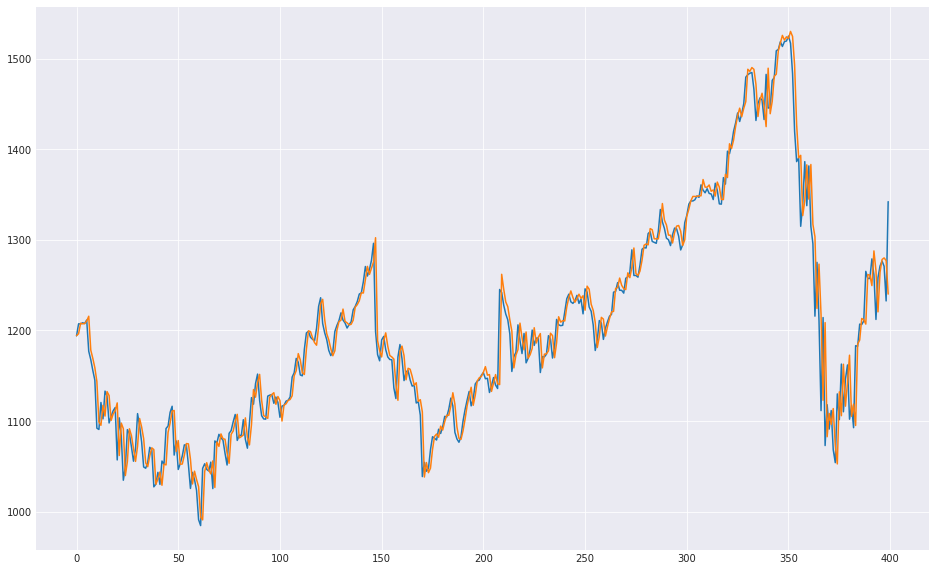

In [395]:
plt.plot(y_test[:, 1])
plt.plot(ypred[:, 1])

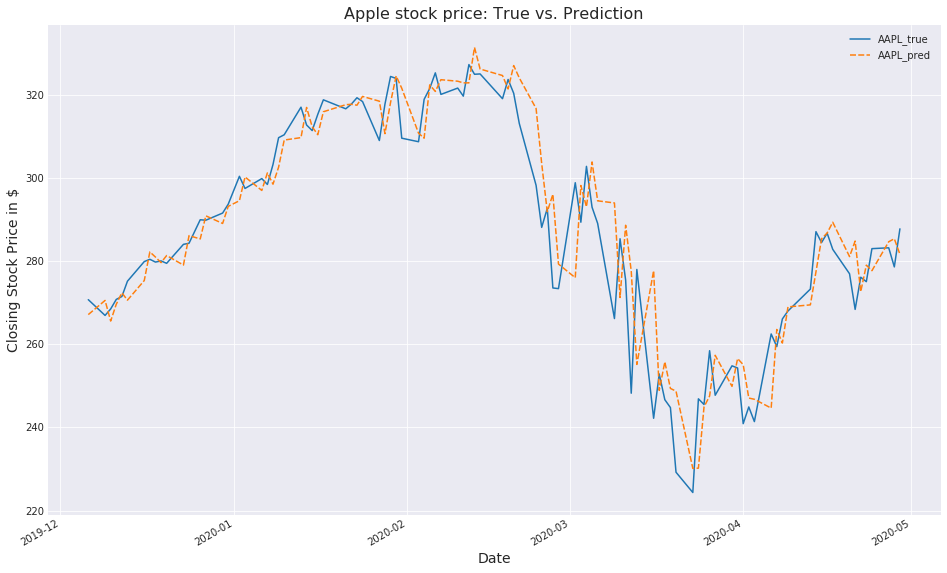

In [25]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

1. Play with the above code to get familiar with stock price data and ways to create training data ( X = past stock price, y = future stock price )

2. Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )
3. Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
4. Build a linear regression model to predict future stock price
5. Evaluate your model performance